### MA5851: Assignment 3, Webcrawler & NLP
#### Paul Kirkwood

#### Overview
##### Objective
Sport is based upon emotion,none more so than football. In the 1990's the satellite broadcaster, Sky,  revolutionised football through it's multi billion dollar investment in the English Premier League.It understood the value of emotion in capturing customers.

The analysis of emotion or sentiment of games is useful in understanding whether emotion is just a transitory factor or whether there are trends and patterns in emotion that go beyond the specific match on the day. Questions such as, do some matches generate higher or lower sentiments over time?  Are there particular events in matches that generate significantly changed sentiment responses.

For the media platforms this may enable:

- match planning,
- scheduling high sentiment games at particular times.
- Designing in game entertainment, do certain sentiment levels benefit from external input, such as pundit discussion.
- Can sentiment tracking govern when ad breaks occur or coverage interruptions.
- Are there variances between live visual coverage and non-visual?

All of these questions can influence not just coverage planning, but the management of advertising revenue. On the 'dark side', can sentiment tracking be used by betting companies to pitch offers or adjust odds, or by advertising companies.

##### Data Sources

With the growth in media platforms focused on very narrow segments of the fan base for games we are able to isolate fan groups to narrowly focus the collection of data for sentiment analysis.

There are multiple pathways such as twitter, facebook, etc., that can generate significant volumes of data and would require significant comutation to manage.  They are also global platforms and further work is required to generate granular data that can be attributed to specific countries or market segments.

The growth in fan forum platforms, many of which are run by clubs or organisations affiliated to clubs offer a very useful sample set on which to test the concept.  Affiliated fan sites are moderated, single language, and in most cases require registration. A particular forum thread is discrete, off topic posts are moderated.  The message data is therefore tightly focused on the subject matter (ie the game) and content is developed by club fans (opposition fans will not post on a club site.) this gives us a very clear data set to work with.

##### Structure of the Analysis
The task aims to capture sentiment from forum match feeds to use as the basis for sentiment analysis.  Event data (eg. goals) or library data (eg. player names) will be captured from other websites to provide context data.

The structure of the model is outlined below:


### Webcrawler
##### Background
The webcrawler will obtain data from the following sites;

| Website   | Description|
| --------- |------------|
| www.forums.liverpoolfc.com       | Official Club fan forum site.  Individual match threads can be scraped for analysis           |
| www.liverpoolfc.com| Club home page with most up to date squad |
| www.turboscores.com| match reporting site that provides detailed game stats including goal scorers and goal timing|

##### Forum Scraping
The forum site is created in html and is visually rich with a very high degree of style management to assist in user navigation and to provide a look and feel appropriate to a major global football club.

A review of the sites terms and conditions did not specifically prohibit web scraping and initial test requests all returned [200] responses.  The site is publicly accessible and all forum threads and posts can be accessed without login or other security measure.  User data for contributors is locked and requires paid membership. This is not an issue for this task.
Given the project is using the publicly available data, is not restricted, nor is protected by CloudFlare or similar, I have assumed that the data can be scraped for the purposes of this assignment. Further investigation would be needed to determine if repeated requests or if the data is to be commercially used. In these circumstances, copyright restrictions may be an issue.

This prototype scraper will use a specific match for, namely the sublime victory over the rather desperate Arsenal that was played on 20th November 2021.
Any match can be selected from the forum as all match day threads are retained.
The webcrawler is created using Python requests() and BeautifulSoup4()

In [ ]:
import numpy as np
import requests
page = requests.get('https://forums.liverpoolfc.com/threads/407628-Liverpool-v-Arsenal-Saturday-20th-November-KO-17-30')
page #generates a [200] response confirming the request was successful

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')
print(soup.find('title').get_text())
kickoff = soup.find('title').get_text()

In [ ]:
print([type(item) for item in list(soup.children)])


In [ ]:
html = list(soup.children)[2] #select the 'tag' child
#list(html.children)  # tag list is commented out to minimise the print out.

An analysis of the child tags identified that the forum 'post test' is contained within the '< div>' tag and < class> = content. This class contained significant data including details of the poster together with a high level of style data.

Investigation narrowed the relevant content location to the following tags:
- Post content:     tag = < blockquote >, class = 'postcontent restore'
- Post timestamp:   tag = < span>, class = 'date

The data is extracted, stripped of html css code and stored in a dataframe for later use.
As a forum site, the content is limited to around 30 posts per page, a page turn loop is created to allow the scraper to work over multiple pages. for the purposes of this prototype, the page count is limited to 10, ~300 posts.

In [ ]:
page_num=1
df = []
while page_num != 10:
    url= f'https://forums.liverpoolfc.com/threads/407628-Liverpool-v-Arsenal-Saturday-20th-November-KO-17-30'+'/page'+str(page_num)
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')
    page2 = soup.find_all("div", {"class":"postbody"})
    for k in page2:
        item2 = k.find('blockquote', class_="postcontent restore")
        post = k.find('span', class_='date')
        post_text = post.get_text().strip()
        text2 = item2.get_text().strip()
        #print(post_text)
        #print(text2)
        df.append([post_text, text2])

    page_num = page_num+1

In [ ]:
import pandas as pd
df = pd.DataFrame(df)
df.columns = ['date','post']
df[['date', 'time']] = df['date'].str.split(',',expand=True)
df = df[['date', 'time', 'post']]
df.dtypes

In [ ]:
df.shape

In [ ]:
df['date']= pd.to_datetime(df['date'])
df['time']= pd.to_datetime(df['time'])
#df['time'] = pd.Series([val.time() for val in df['time']])
df['post']= df['post'].astype(str)
df.head()

A review of the text content requires further cleaning as follows:
- The text content contains html characters that were unable to be removed by the strip function, these are to be removed.
- Punctuation and emoji's are to be left in as these have a significant impact upon sentiment analysis.  "!" for example will greatly increase the sentiment score of the preceding sentence.
- 're-posting' or 'quoting' of previous comments will be left in as these reinforce the sentiment of the previous comment.


In [ ]:
df['post'] = df['post'].str.replace('\\n',' ')
df['post'] = df['post'].str.replace('\\r',' ')
#df['post'] = df['post'].str.replace('.,',' ')
char = ".,-"
for i in char:
    df['post'] = df['post'].str.replace(i, " ")
df.head()

##### Team Player Data Scraping
Player data is scraped from the live player squad page on the Liverpool FC website. The methodology is similar to the post content scraping above, however, the site content is far simpler to extract from as it is a fixed page with static data and not a continually updating page as found in forum sites.
AS before for the Liverpool sites, there appear to be few restrictions on accessing the player data. It is likely in this instance that the player names are 'advertising' to some degree as they are used to provide links to club merchandising.
The data contained far higher numbers of tags, and the relevant child was number 13 of 14 identified.

In [ ]:
names = []
page = requests.get('https://www.liverpoolfc.com/team/first-team')
soup = BeautifulSoup(page.content, 'html.parser')
for player in soup.find_all(class_="name"):
    name = player.get_text(strip=True, separator=' ')
    names.append(name)
print(names)

names = pd.DataFrame(names)
names.columns = ['Names']
names

##### Match Event Data Scraping
Match data is scraped from a fan site that appears to source data from multiple sources. An examination of the site code notes links to other sites.
This presents a potentially complex copyright and intellectual property challenge as it is unclear whether the sites author has the appropriate authorities to use or publish this data. It was noted that while there are many similar sites, of those tested only a few provided [200] response codes, with many returning [403] codes that suggest content restrictions are in place, potentially because of the pass through copyright issues.

The site itself, for data scraping required careful navigation; the data is presented graphically and care was needed to drill down to the underlying text data that was being used to call images and icons.

The data ultimately was extracted as a simple list, however, extraction into a suitable dataframe was involved and required several wrangling steps.

In [106]:
events = []
page = requests.get('https://www.turboscores.com/match/691402/Liverpool-v-Arsenal')
soup = BeautifulSoup(page.content, 'html.parser')

for k in soup.find_all("div", {'id':'s1'}):
     event = k.get_text(strip=True, separator="-")

In [107]:
l = event.split('-')
df3 = pd.DataFrame(l)
slice = df3.iloc[::2]
slice.columns = ['time']
slice.reset_index(drop=True, inplace=True)
slice2 = df3.iloc[1::2]
slice2.columns = ['scorer']
slice2.reset_index(drop=True, inplace=True)
events = pd.concat([slice, slice2], axis=1)
events['time'] = events['time'].str.replace("'",'')
events['goal'] = 1
events = events.drop([2,4])
events

,time,scorer,goal
0,77,Takumi Minamino,1
1,73,Mohamed Salah,1
3,52,Diogo Jota,1
5,39,Sadio Mané,1


The final wrangling step is to align the event (goal scored time) with the match time to allow both to be plotted on the same graph.

In [109]:
from datetime import datetime, timedelta
kickoff
kickoff_time = kickoff[-5:]
kickoff_time = pd.to_datetime(kickoff_time)
kickoff_time

Timestamp('2021-12-05 17:30:00')

In [110]:
def time_a(row):
    return kickoff_time + timedelta(minutes=int(row['time']))
events['score_time'] = events.apply(time_a, axis=1)
#events['score_time'] = pd.Series(val.time() for val in events['score_time'])
events

,time,scorer,goal,score_time
0,77,Takumi Minamino,1,2021-12-05 18:47:00
1,73,Mohamed Salah,1,2021-12-05 18:43:00
3,52,Diogo Jota,1,2021-12-05 18:22:00
5,39,Sadio Mané,1,2021-12-05 18:09:00


### NLP Prototype

##### Overview
The aim of the NLP is to assess the sentiment over the course of the match as it potentially ebbs and flows and how this is influenced by goals.

The NLP will be carried out using the NLTK suite of NLP tools within python, as follows;
- The corpus will be cleaned to remove stopwords (using the NLTK Stopwords library) in order to isolate the critical sentiment driving key works. Removal of stopwords will increase the relative frequency of keywords as a part of the whole corpus.
- The words within the corpus will also be stemmed using the SnowballStemmer function applied to the cleaned corpus. The intent here is to reduce the number of key words to stemmed sets, thereby increasing the frequency of keywords and phases. Prior to stemming, it was noted that the test contained some numeric values that returned errors and hence these were removed. The downside to stemming is that the algorithm naturally converted all works to lower case, this was not the preferred outcome as the sentiment analysis recognises the impact on sentiment arisign from capitalised words.  The sentiment analysis will explore the variance between a stemmed and non-stemmed corpus.
- Sentiment analysis will be carried out using Vader from NLTK returning the expected positive, neutral, negative and compound variables.  In addition, new variables will be generated using average and cumulative data to assess the sentiment trends and overall quality metrics.
- Finally, the data will be displayed visually to provide a useful tool for assessment of sentiment.

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import WhitespaceTokenizer as wst
%matplotlib inline

In [ ]:
stop = stopwords.words('english')
for i in stop:
    df['post'] = df['post'].replace(to_replace=r'\b%s\b\d'%i, value="",regex=True)
stemmer = SnowballStemmer('english')
df['stemmed'] = df['post'].apply(lambda x: stemmer.stem(x))


In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

df['compound'] = [sid.polarity_scores(x)['compound'] for x in df['post']]
df['neg'] = [sid.polarity_scores(x)['neg'] for x in df['post']]
df['neu'] = [sid.polarity_scores(x)['neu'] for x in df['post']]
df['pos'] = [sid.polarity_scores(x)['pos'] for x in df['post']]

In [ ]:
df.head()

In [ ]:
import statistics
data_mean = df.mean()
data_var = df.var()
data_max = df.max()
data_min = df.min()
df1= pd.Series(data_mean, name="Mean Values")
df2= pd.Series(data_var, name='Variance')
df3= pd.Series(data_max, name= 'Max')
df4= pd.Series(data_min, name= 'Min')
combined= pd.concat([df1, df2, df3, df4], axis=1)
combined.dropna(inplace=True)

A simple exploration of the data derived from the sentiment data provided the following insights.
- There was only a marginal difference between the positive & negative mean values, that initially suggests that the match was evenly balanced. However, this match was a strong win for Liverpool and hence the expectation is that the sentiment would be strongly positive.  My assumption is that the methodology has normalised the values between 0 and 1 and hence the two values cannot be compared on scale.
- From the box plot it can be seen that the compound value is skewed towards the positive sentiment (ie. value > 0) this would be reflective of the overall match outcome.
- In both positive and negative values, the spread includes several values that could be considered outliers. The hypothesis here is that these may coincide with goals scored or key misses of which the number in the match is raltively low in comparision to the number of comments.

In [ ]:
combined.head()
df_plot = df[['compound', 'neg', 'neu', 'pos']]

In [ ]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots()
plt.boxplot(df_plot)
plt.xticks([1,2,3,4],["Compound", "neg", "neu", "pos"])
plt.show()

In [88]:
df_match = df[['time', 'compound', 'neg','neu','pos']].copy()
df_match['neg'] = df_match['neg']*-1

An initial plot of the four sentiment variables from the fully extracted dataset identified issues relating to the management of timeseries data, but also noted that the forum site was open for over 24hours.  The time period of interest is the match itself, this period can be identified from the chart as the dense period in the last quarter.  The plot also shows some quiet periods of low or very low posting, overnight and in the immediate lead up to the game.

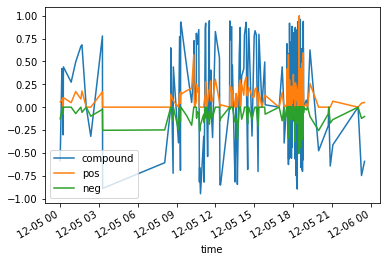

In [89]:
df_match.plot(x='time', y = ['compound', 'pos', 'neg'])
plt.show()

In [114]:
df_match['time'] = pd.to_datetime(df_match['time'])
start = datetime.strptime('17:30:00', '%H:%M:%S').time()
end = datetime.strptime('19:00:00', '%H:%M:%S').time()
df_filter = df_match[df_match['time'].dt.time.between(start, end)]

By filtering the data to isolate the match period, a more representative plot can be achieved. However, the filtering and management of time data required considerable wrangling. It may be possible to better refine the scraped data to ease this process.

In [ ]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate

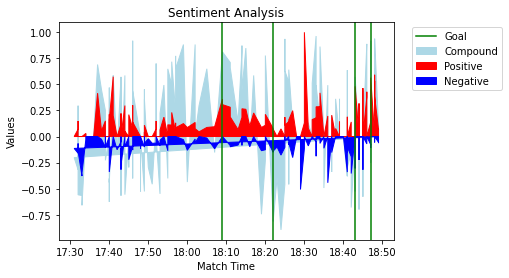

In [115]:
X = df_filter['time']
X = X.sort_values()
Y1 = df_filter['pos']
Y2 = df_filter['compound']
Y3 = df_filter['neg']
Goal = events['goal']
Goal_time = events['score_time']


num_goal = len(Goal_time)
plt.fill(X, Y2, color = 'lightblue', label = 'Compound')
plt.fill(X, Y1, color = 'r', label = 'Positive')
plt.fill(X, Y3, color = 'b', label = 'Negative')
for i in range(num_goal):
    plt.axvline(x=Goal_time.iloc[i], color = 'g', label = 'Goal')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title("Sentiment Analysis")
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.04,1), loc='upper left')
plt.ylabel('Values')
plt.xlabel('Match Time')
h_fmt = mdate.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(h_fmt)
hours = mdate.HourLocator(interval=1)
ax.xaxis.set_major_locator(hours)
plt.show()

The intended output was achieved in the plot above. Clearly shown are the relative positive and negative sentiment scores tracking over time throughout the match. Initial observations:

The compound sentiment value confirms the finding from the EDA, it is weighted positive indicting overall a more positive than negative sentiment.

The negative sentiment value trends upwards, suggesting that overall sentiment became less negative as the match progressed. Understandable given the performance and scoreline.

There is noticeable spikes in positve sentiment associated with goals score, as woudl be expected.

There are other noticeable spikes in both positive and negative sentiment.
- The first group is around kickoff when the excitement and anxiety would be higher with anticipation.
- A significant spike occurs at the one-hour mark, approximately 6:30pm. An analysis of the time period from 55minutes to 65minutes confirmed two incidents occured, firstly a significant injury to a Liverpool Player, followed by a critical save by the Liverpool goalkeeper. This sentiment spike is as much a sense of relief as excitement.

Reading the match report back and aligning the sentiment movements with match activity confirms that the sentiment tracker is performing well.

### Conclusions & Recommendations
##### Conclusions
The 


109   2021-12-05 17:31:00
110   2021-12-05 17:32:00
113   2021-12-05 17:32:00
112   2021-12-05 17:32:00
111   2021-12-05 17:32:00
              ...        
266   2021-12-05 18:49:00
268   2021-12-05 18:49:00
264   2021-12-05 18:49:00
265   2021-12-05 18:49:00
269   2021-12-05 18:49:00
Name: time, Length: 168, dtype: datetime64[ns]